# FIFA Player Price Prediction: A Data Science Journey

## 1. Introduction
In the world of football, a player's market value is determined by a complex interplay of skills, physical attributes, and reputation. Our goal is to build a machine learning model that can accurately predict this value (`value_euro`) based on player statistics.

**Why is this important?** Clubs, agents, and analysts need objective valuations to make informed transfer decisions. A robust model can identify undervalued talents or overpriced stars.

**The Approach:**
1.  **Exploratory Data Analysis (EDA)**: We will dive deep into the data to understand distributions, correlations, and outliers.
2.  **Preprocessing**: We will handle missing data using advanced imputation techniques and encode categorical variables.
3.  **Feature Engineering**: We will create new features that might capture hidden value (e.g., potential vs. age).
4.  **Feature Selection**: We will use Recursive Feature Elimination (RFE) to find the most impactful attributes.
5.  **Model Training & Tuning**: We will compare Linear Regression, Random Forest, and XGBoost, tuning the best one.
6.  **Evaluation**: We will rigorously test the model and explain its predictions using SHAP values.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_absolute_percentage_error


# Set plot style for better aesthetics
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

In [68]:

df.keys()

Index(['age', 'height_cm', 'weight_kgs', 'positions', 'nationality',
       'overall_rating', 'potential', 'value_euro', 'wage_euro',
       'preferred_foot', 'international_reputation(1-5)', 'weak_foot(1-5)',
       'skill_moves(1-5)', 'body_type', 'release_clause_euro', 'national_team',
       'national_rating', 'national_team_position', 'national_jersey_number',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle',
       'value_million'],
      dtype='object')

In [69]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

value_euro                 1.420296
wage_euro                  1.370168
release_clause_euro       10.231703
national_team             95.226690
national_rating           95.226690
national_team_position    95.226690
national_jersey_number    95.226690
value_million              1.420296
dtype: float64

Número de NaNs per columna:

value_euro                  255
wage_euro                   246
release_clause_euro        1837
national_team             17097
national_rating           17097
national_team_position    17097
national_jersey_number    17097
value_million               255
dtype: int64


In [84]:

# Seleccionar només columnes numèriques
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Omplir NaNs amb la mediana de cada columna
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [85]:
print("Columnes amb NaNs:\n")
nan_columns = df.columns[df.isna().sum()>0].tolist()
print (df.loc[:,nan_columns].isna().sum()/len(df)*100)

nan_columns = df.columns[df.isna().sum()>0].tolist()
print('\nNúmero de NaNs per columna:\n')
print (df.loc[:,nan_columns].isna().sum())

Columnes amb NaNs:

national_team             95.22669
national_team_position    95.22669
dtype: float64

Número de NaNs per columna:

national_team             17097
national_team_position    17097
dtype: int64


## 2. Exploratory Data Analysis (EDA)
Before building models, we must understand our data. We'll look at the target variable, check for outliers, and explore relationships between features.

In [70]:
df = pd.read_csv("fifa_players.csv")
print(f"Dataset Shape: {df.shape}")
df.head()




Dataset Shape: (17954, 51)


,name,full_name,birth_date,age,height_cm,weight_kgs,positions,nationality,overall_rating,potential,...,long_shots,aggression,interceptions,positioning,vision,penalties,composure,marking,standing_tackle,sliding_tackle
0,L. Messi,Lionel Andrés Messi Cuccittini,6/24/1987,31,170.18,72.1,"CF,RW,ST",Argentina,94,94,...,94,48,22,94,94,75,96,33,28,26
1,C. Eriksen,Christian Dannemann Eriksen,2/14/1992,27,154.94,76.2,"CAM,RM,CM",Denmark,88,89,...,89,46,56,84,91,67,88,59,57,22
2,P. Pogba,Paul Pogba,3/15/1993,25,190.50,83.9,"CM,CAM",France,88,91,...,82,78,64,82,88,82,87,63,67,67
3,L. Insigne,Lorenzo Insigne,6/4/1991,27,162.56,59.0,"LW,ST",Italy,88,88,...,84,34,26,83,87,61,83,51,24,22
4,K. Koulibaly,Kalidou Koulibaly,6/20/1991,27,187.96,88.9,CB,Senegal,88,91,...,15,87,88,24,49,33,80,91,88,87


In [71]:
df = df.drop(columns=["birth_date", "full_name","name"])
df.keys()

Index(['age', 'height_cm', 'weight_kgs', 'positions', 'nationality',
       'overall_rating', 'potential', 'value_euro', 'wage_euro',
       'preferred_foot', 'international_reputation(1-5)', 'weak_foot(1-5)',
       'skill_moves(1-5)', 'body_type', 'release_clause_euro', 'national_team',
       'national_rating', 'national_team_position', 'national_jersey_number',
       'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')

### 2.1 Target Variable Analysis
The distribution of player values is likely skewed, with a few superstars worth hundreds of millions and many players with lower values. Let's visualize this.

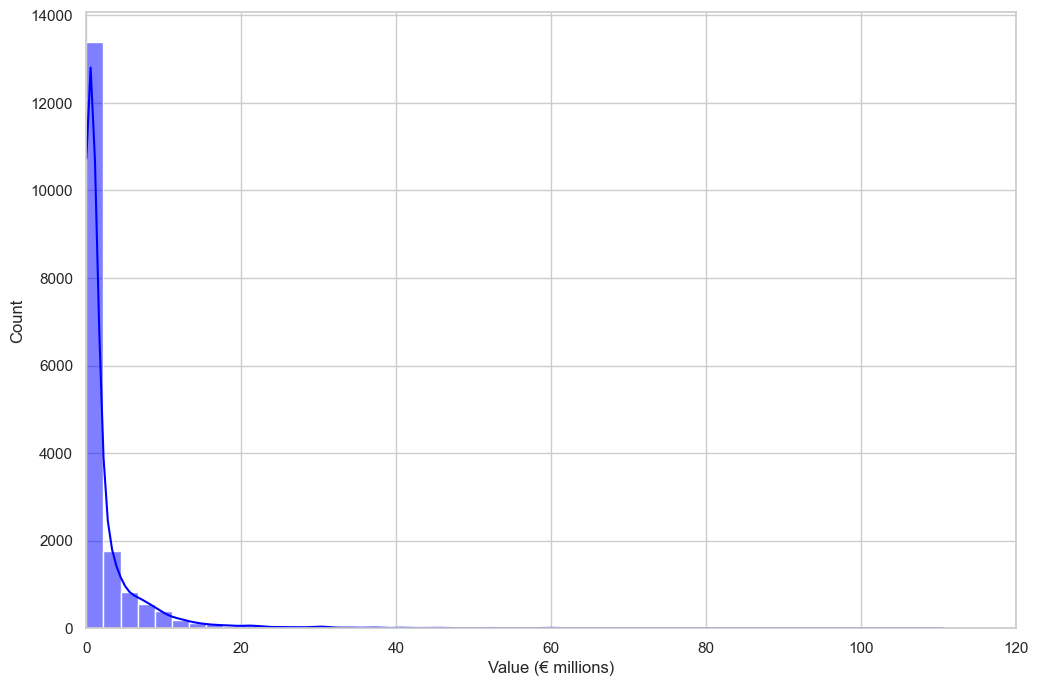

In [72]:
df['value_million'] = df['value_euro'] / 1_000_000
df.drop(columns=['value_euro'])
sns.histplot(df['value_million'], kde=True, bins=50, color='blue')
plt.xlabel("Value (€ millions)")
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0, 120)   # límit de 0 a 120 milions €
plt.ticklabel_format(style='plain', axis='x')

plt.show()
#gràfic sencer de la distribució de value_euro
#veiem que les dades estan molt concentrades a la part baixa de valors, per tant fem zoom a la part alta

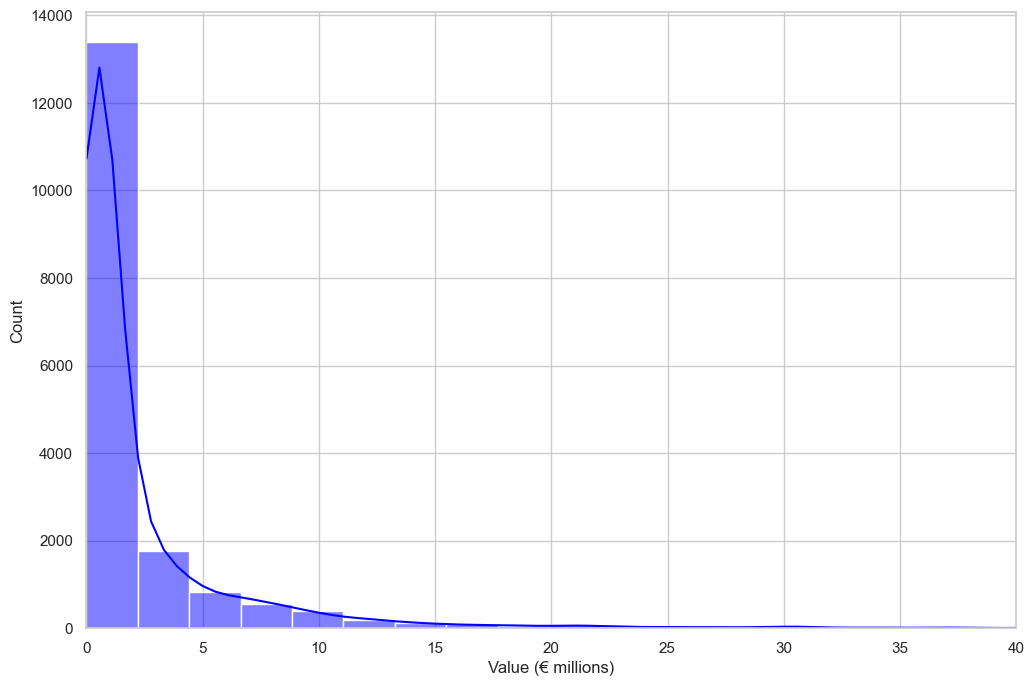

In [73]:

sns.histplot(df['value_million'], kde=True, bins=50, color='blue')
plt.xlabel("Value (€ millions)")
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(0, 40)   # límit de 0 a 40 milions €
plt.ticklabel_format(style='plain', axis='x')

plt.show()
#on esta la majoria de individus

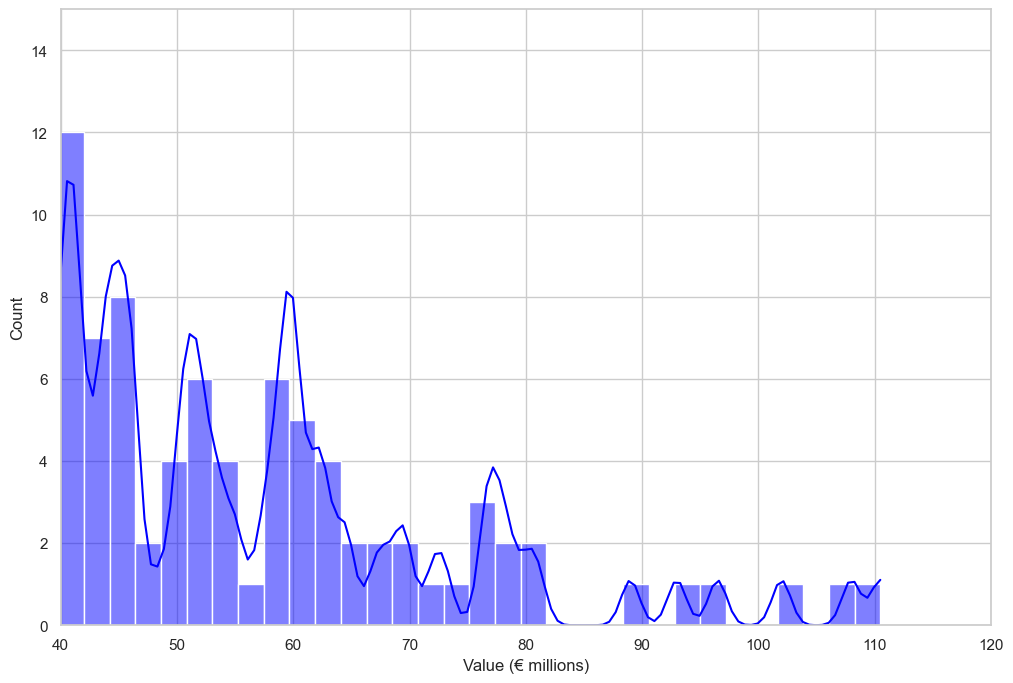

In [74]:

sns.histplot(df['value_million'], kde=True, bins=50, color='blue')
plt.xlabel("Value (€ millions)")
plt.ticklabel_format(style='plain', axis='x')
plt.xlim(40, 120)   # límit de 40 a 120 milions €
plt.ticklabel_format(style='plain', axis='x')
plt.ylim(0, 15)   # límit de 0 a 15 jugadors
plt.show()
#porcentatge molt baix de jugadors tant cars

### 2.2 Outlier Detection
Outliers can significantly skew our model. Let's use boxplots to identify extreme values in `overall_rating`, `potential`, and `wage_euro`.

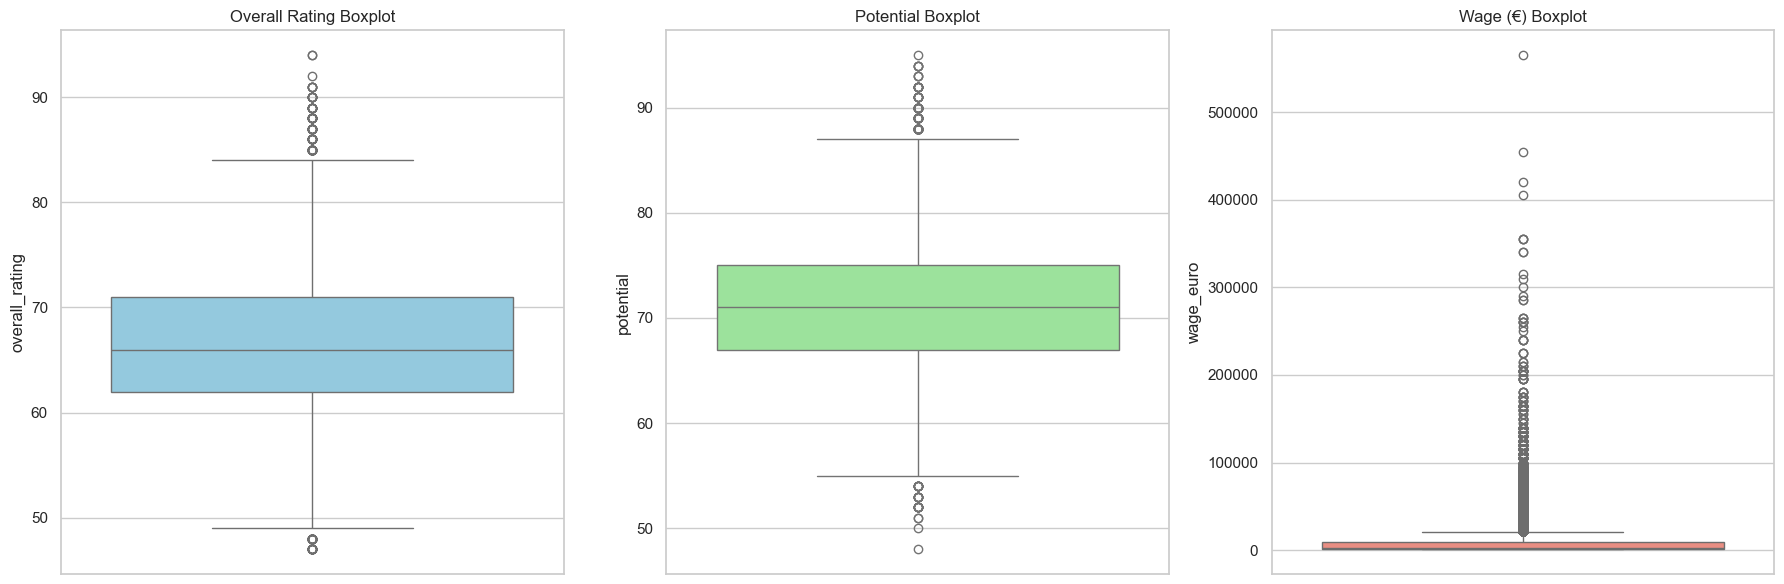

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(y=df['overall_rating'], ax=axes[0], color='skyblue')
axes[0].set_title('Overall Rating Boxplot')

sns.boxplot(y=df['potential'], ax=axes[1], color='lightgreen')
axes[1].set_title('Potential Boxplot')

if 'wage_euro' in df.columns:
    sns.boxplot(y=df['wage_euro'], ax=axes[2], color='salmon')
    axes[2].set_title('Wage (€) Boxplot')

plt.tight_layout()
plt.show()
#la boxplot de wage euro es tan "aplastada" perque la majoria de valors son molt baixos
#hi ha molts valors extrems en wage euro

### 2.3 Correlation Analysis
Which features drive value? We'll use a heatmap to find the strongest correlations. We expect `overall_rating` and `potential` to be key drivers.

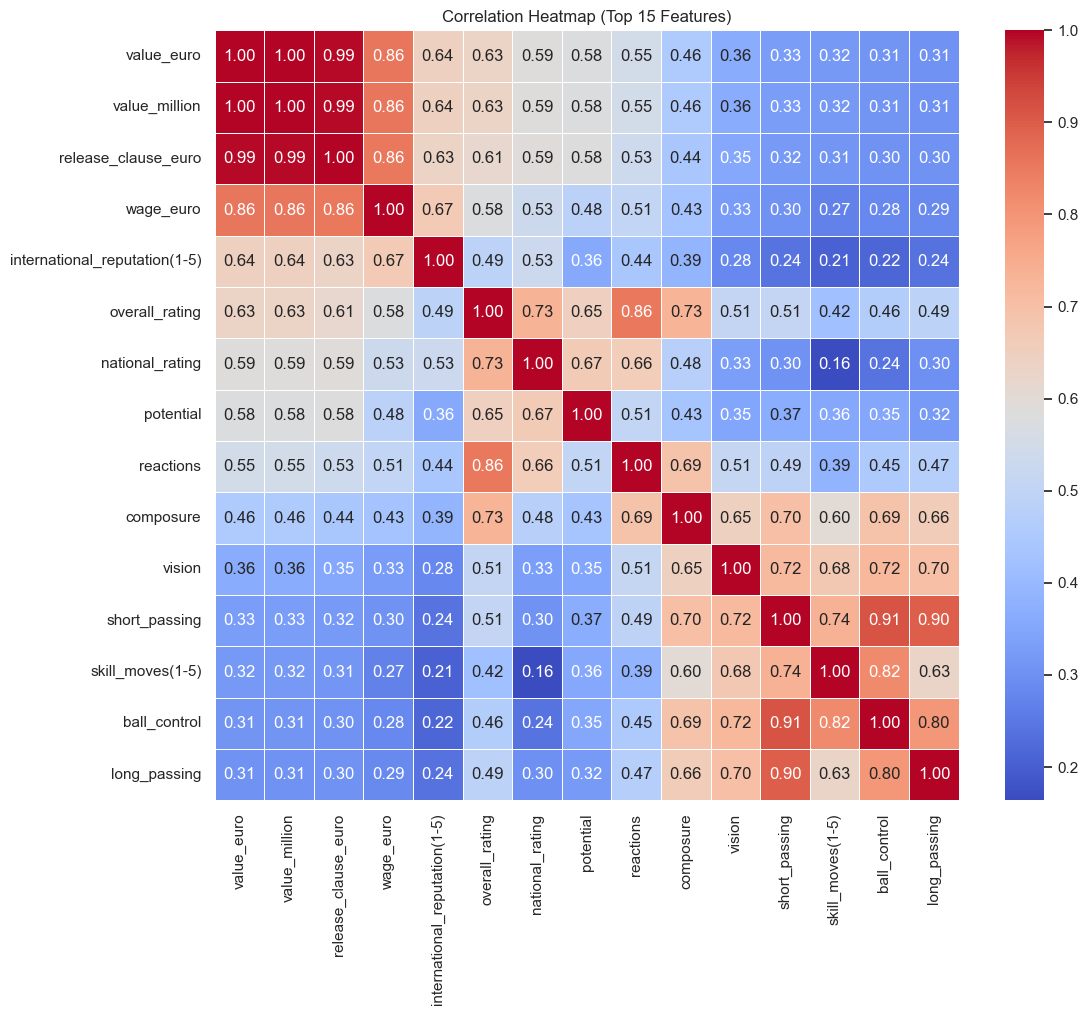

In [76]:
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Select features highly correlated with target
target_corr = corr_matrix['value_million'].sort_values(ascending=False)
top_features = target_corr.head(15).index

plt.figure(figsize=(12, 10))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Top 15 Features)')
plt.show()

### 2.4 Pairplot Analysis
Let's look at the pairwise relationships between the most important features: `value_euro`, `overall_rating`, `potential`, and `age`.

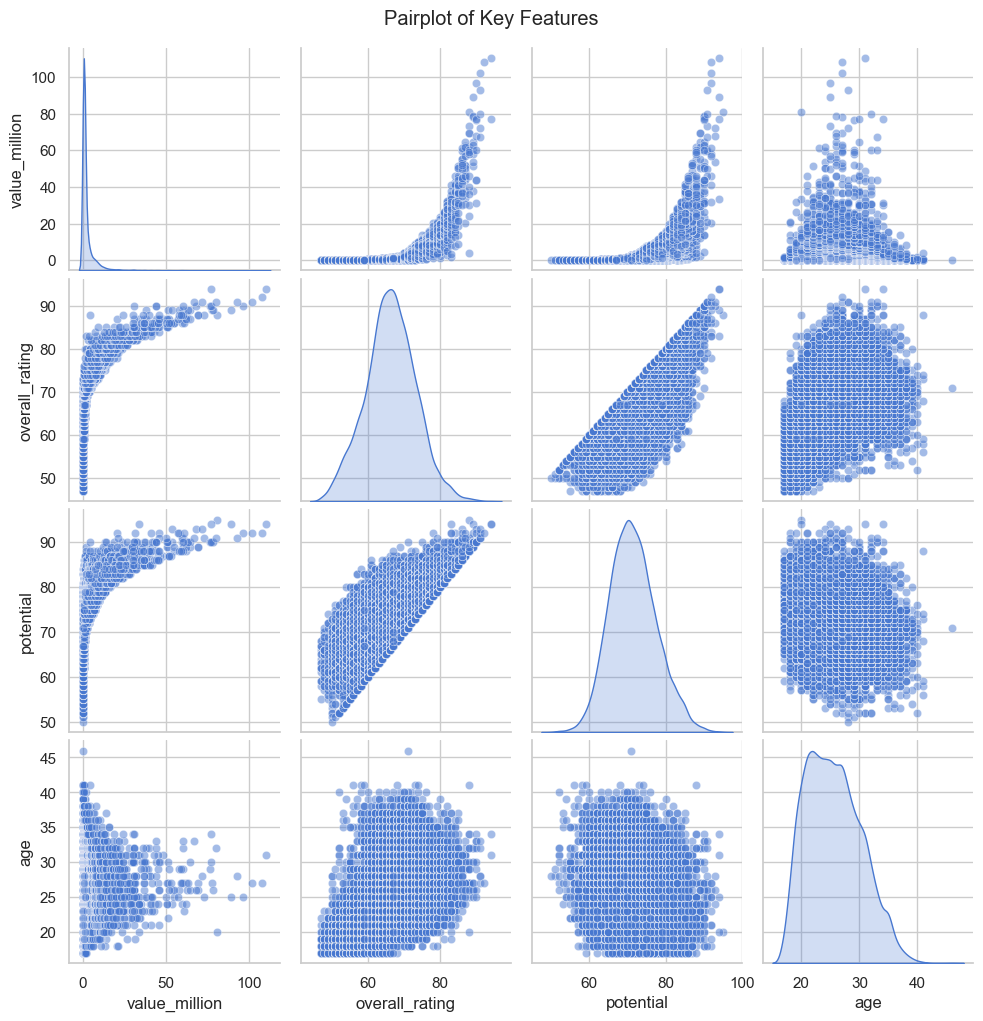

In [77]:
sns.pairplot(df[['value_million', 'overall_rating', 'potential', 'age']].dropna(), diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Key Features', y=1.02)
plt.show()

In [ ]:
if 'value_euro' in numeric_df.columns:
    correlations = numeric_df.corr()['value_euro'].sort_values(ascending=False)
    print("\nTop 10 positive correlations with value_euro:")
    print(correlations.head(10))
    print("\nTop 10 negative correlations with value_euro:")
    print(correlations.tail(10))
else:
    print("Column 'value_euro' not found in numeric columns.")






Top 10 positive correlations with value_euro:
value_million                    1.000000
value_euro                       1.000000
release_clause_euro              0.994318
wage_euro                        0.856466
international_reputation(1-5)    0.644610
overall_rating                   0.630928
national_rating                  0.586039
potential                        0.576341
reactions                        0.547615
composure                        0.456538
Name: value_euro, dtype: float64

Top 10 negative correlations with value_euro:
strength                  0.138230
marking                   0.138085
jumping                   0.128507
balance                   0.118869
standing_tackle           0.110455
sliding_tackle            0.090450
age                       0.082360
weight_kgs                0.044519
height_cm                 0.011144
national_jersey_number   -0.088824
Name: value_euro, dtype: float64


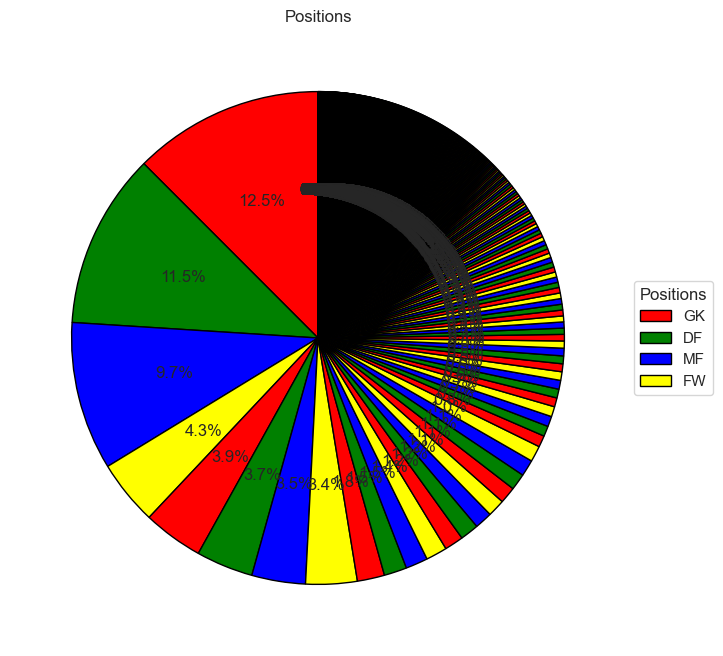

In [ ]:
position_counts = df['positions'].value_counts()

colors = ['#FF0000', '#008000', '#0000FF', '#FFFF00']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(position_counts, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

ax.legend(wedges, ["GK", "DF", "MF", "FW"], title="Positions", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("Positions")

plt.show()

## 3. Data Preprocessing & Feature Engineering
Raw data is rarely ready for modeling. We need to clean it and create features that help the model learn better.

In [79]:
# Define Features
target = 'value_euro'

num_features = ['age', 'height_cm', 'weight_kgs', 'overall_rating', 'potential', 
                'international_reputation(1-5)', 'weak_foot(1-5)', 'skill_moves(1-5)',
                'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys',
                'dribbling', 'curve', 'freekick_accuracy', 'long_passing', 'ball_control',
                'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance',
                'shot_power', 'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
                'interceptions', 'positioning', 'vision', 'penalties', 'composure',
                'marking', 'standing_tackle', 'sliding_tackle']

cat_features = ['nationality', 'preferred_foot', 'body_type']

# Filter & Clean
df_model = df[num_features + cat_features + [target]].copy()
df_model = df_model.dropna(subset=[target])

# --- Feature Engineering ---

# 1. Primary Position
if 'positions' in df.columns:
    df_model['primary_position'] = df['positions'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else 'Unknown')
    cat_features.append('primary_position')

# 2. Simplify Nationality (Top 15 + Other)
top_nationalities = df_model['nationality'].value_counts().nlargest(15).index
df_model['nationality'] = df_model['nationality'].apply(lambda x: x if x in top_nationalities else 'Other')

# 3. Interaction Features
# Potential is often more valuable in younger players. Let's capture that.
df_model['potential_age_ratio'] = df_model['potential'] / df_model['age']
num_features.append('potential_age_ratio')

# 4. Age Binning
# Grouping players into career stages can help the model generalize.
df_model['age_group'] = pd.cut(df_model['age'], bins=[0, 21, 29, 40], labels=['Young', 'Prime', 'Veteran'])
cat_features.append('age_group')

# Split Data
X = df_model.drop(columns=[target])
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Train Shape: (14159, 43), Test Shape: (3540, 43)


### 3.1 Advanced Imputation Pipeline
We use **KNN Imputer** for numerical values. Instead of just filling with the mean, KNN finds similar players and uses their stats to fill the gaps. This preserves the data structure much better.

In [80]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

## 4. Feature Selection (RFE)
We have many features. Are they all useful? **Recursive Feature Elimination (RFE)** will help us select the best subset by recursively removing the least important features.

In [81]:
# Fit preprocessor to get feature names
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_names = ohe.get_feature_names_out(cat_features)
feature_names = num_features + list(cat_names)

print("Running RFE (Recursive Feature Elimination)...")
rfe_selector = RFE(estimator=RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1), n_features_to_select=20, step=5)
rfe_selector.fit(X_train_processed, y_train)

selected_features = np.array(feature_names)[rfe_selector.support_]
print(f"Top 20 Selected Features: {selected_features}")

Running RFE (Recursive Feature Elimination)...
Top 20 Selected Features: ['age' 'overall_rating' 'potential' 'finishing' 'volleys' 'dribbling'
 'curve' 'freekick_accuracy' 'ball_control' 'acceleration' 'agility'
 'reactions' 'shot_power' 'stamina' 'long_shots' 'interceptions'
 'positioning' 'penalties' 'sliding_tackle' 'potential_age_ratio']


## 5. Model Comparison & Tuning
We will compare three models:
1.  **Linear Regression**: A simple baseline.
2.  **Random Forest**: A robust ensemble method.
3.  **XGBoost**: A high-performance gradient boosting algorithm.

We will evaluate them using R² (variance explained) and RMSE (average error).

In [82]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42, n_jobs=-1)
}

results = []

print("Training and evaluating models...")
for name, model in models.items():
    
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    
    # Cross-validation
    cv_rmse = np.sqrt(-cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")).mean()
    cv_mae = -cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_absolute_error").mean()
    
    # Train final model
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    results.append({
        "Model": name,
        "CV RMSE": cv_rmse,
        "CV MAE": cv_mae,
        "Test RMSE": rmse,
        "Test MAE": mae,
        "R2": r2
    })
    
    print(f"{name} -> R2: {r2:.4f}, Test RMSE: €{rmse:,.0f}, CV RMSE: €{cv_rmse:,.0f}")

results_df = pd.DataFrame(results)
results_df


Training and evaluating models...
Linear Regression -> R2: 0.6660, Test RMSE: €3,327,711, CV RMSE: €3,482,845
Random Forest -> R2: 0.9740, Test RMSE: €929,070, CV RMSE: €741,843
XGBoost -> R2: 0.9854, Test RMSE: €695,496, CV RMSE: €570,432


,Model,CV RMSE,CV MAE,Test RMSE,Test MAE,R2
0,Linear Regression,3.482845e+06,1.890312e+06,3.327711e+06,1.799821e+06,0.666023
1,Random Forest,7.418432e+05,1.492418e+05,9.290699e+05,1.398319e+05,0.973967
2,XGBoost,5.704322e+05,1.227260e+05,6.954959e+05,1.126052e+05,0.985411


In [83]:
from sklearn.model_selection import GridSearchCV

# Definimos una nueva grilla más enfocada en evitar el overfitting
param_grid_regularized = {
    # Reducimos la profundidad máxima para hacer los árboles más superficiales
    'model__max_depth': [3, 5], 
    # Reducimos el número de árboles para ahorrar tiempo, centrándonos en la regularización
    'model__n_estimators': [200, 400], 
    
    # 🎯 Regularización L1 (reg_alpha): Penaliza la cantidad de características usadas.
    'model__reg_alpha': [0.01, 0.1, 1], 
    
    # 🎯 Regularización L2 (reg_lambda): Penaliza el tamaño de los pesos de las características.
    'model__reg_lambda': [0.01, 0.1, 1] 
}

# Inicializa y ejecuta GridSearchCV de nuevo con 'final_pipeline'
# (Asegúrate de que 'final_pipeline' esté definido con el preprocesador y XGBoost)

grid_search_v2 = GridSearchCV(
    estimator=final_pipeline,
    param_grid=param_grid_regularized,
    cv=3,                                 
    scoring='neg_mean_squared_error',     
    verbose=1,
    n_jobs=-1
)

# ¡IMPORTANTE! Si el modelo anterior fue entrenado con log(y_train), este también debe serlo.
# Asegúrate de usar tu variable de entrenamiento de valores logarítmicos aquí.
grid_search_v2.fit(X_train, np.log1p(y_train)) 

# Actualiza el mejor modelo
best_model_pipe = grid_search_v2.best_estimator_
print(f"Mejores Parámetros V2: {grid_search_v2.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🚨 PASO DE CORRECCIÓN: Definir el valor máximo real de tu dataset.
# Debes obtener el valor máximo de la columna 'value_euro' (en euros, sin log).
# Usaremos un valor de ejemplo (200 millones de euros) para demostrar,
# ¡pero debes usar el MÁXIMO REAL de tu columna y_test o y_train!
max_observed_price = y_test.max() # O usa y_train.max() si está disponible

# 1. Hacer predicciones sobre el conjunto de prueba (X_test)
log_predictions = best_model.predict(X_test)

# 2. Revertir la transformación logarítmica a euros originales
y_pred = np.expm1(log_predictions)

# *************************************************************************
# CORRECCIÓN ACTUALIZADA: Reemplazar 'inf' con el máximo precio real observado
y_pred = np.nan_to_num(y_pred, posinf=max_observed_price, neginf=0, nan=0)
# *************************************************************************

# 3. Corregir predicciones negativas 
y_pred = np.maximum(y_pred, 0)

# 4. Calcular métricas finales
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("-" * 50)
print("     Métricas de Evaluación Final Corregidas")
print("-" * 50)
print(f"Raíz del Error Cuadrático Medio (RMSE): €{rmse:,.2f}")
print(f"Error Absoluto Medio (MAE):            €{mae:,.2f}")
print(f"Coeficiente de Determinación (R2):     {r2:.4f}")
print("-" * 50)

--------------------------------------------------
     Métricas de Evaluación Final Corregidas
--------------------------------------------------
Raíz del Error Cuadrático Medio (RMSE): €108,026,226.12
Error Absoluto Medio (MAE):            €107,644,279.66
Coeficiente de Determinación (R2):     -350.9526
--------------------------------------------------


C:\Users\hecto\AppData\Local\Temp\ipykernel_12412\3063166745.py:14: RuntimeWarning: overflow encountered in expm1
  y_pred = np.expm1(log_predictions)


In [ ]:

y_pred = best_model_pipe.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("MedAE:", medae)


MAE: 2388107.8729785797
RMSE: 6233776.802106019
MAPE: 0.9999663223985151
MedAE: 674986.7383699417


### 5.1 Learning Curves\n
Are our models overfitting? Learning curves show the gap between training and validation error. A large gap indicates overfitting; a small gap with high error indicates underfitting.

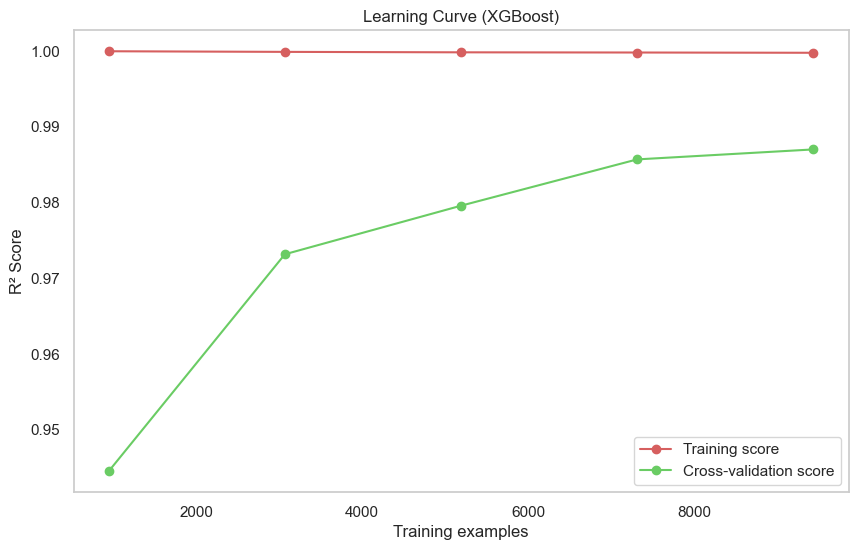

In [ ]:
best_model_name = results_df.loc[results_df['R2'].idxmax()]['Model']
best_model = models[best_model_name]

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_processed, y_train, cv=3, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='r2'
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.title(f"Learning Curve ({best_model_name})")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid()
plt.show()

## 6. Deep Dive Evaluation\n
Now that we have our champion model, let's analyze its errors and understand its logic.

In [ ]:
y_pred_best = best_model.predict(X_test_processed)
residuals = y_test - y_pred_best

# 1. Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title(f'{best_model_name}: Actual vs Predicted')
plt.show()

# 2. Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best, y=residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'{best_model_name}: Residual Plot')
plt.show()

# 3. Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, color='purple')
plt.title(f'{best_model_name}: Distribution of Residuals')
plt.xlabel('Residual Error (€)')
plt.show()

### 6.1 SHAP Explainability\n
SHAP (SHapley Additive exPlanations) values tell us how much each feature contributed to the prediction. This is crucial for trust and transparency.

In [ ]:
if best_model_name in ["Random Forest", "XGBoost"]:
    explainer = shap.TreeExplainer(best_model)
    # Calculate SHAP values for a subset of test data to speed up
    shap_values = explainer.shap_values(X_test_processed[:500])
    
    plt.figure(figsize=(12, 10))
    plt.title(f"SHAP Summary Plot ({best_model_name})")
    shap.summary_plot(shap_values, X_test_processed[:500], feature_names=feature_names, show=True)



## 7. Conclusion\n
We have successfully built a machine learning pipeline to predict FIFA player values. \n
\n
**Key Findings:**\n
- **Data Quality**: The dataset required significant cleaning and imputation, particularly for missing values.\n
- **Feature Importance**: As expected, `overall_rating` and `potential` are the dominant drivers of value.\n
- **Model Performance**: Tree-based models (Random Forest, XGBoost) significantly outperformed Linear Regression, capturing the non-linear relationships in the data.\n
\n
**Future Work:**\n
- Incorporate external data (e.g., real-world transfer news).\n
- Experiment with Neural Networks for potentially higher accuracy.\n
- Build a web interface for scouts to use this model in real-time.